In [1]:
import datetime
import os
import socket
import pickle
import json
from time import time
from types import SimpleNamespace

import matplotlib.pyplot as plt
from matplotlib import collections as mc, patches

import numpy as np
import numpy.random as rd

from lsnn.guillaume_toolbox.matplotlib_extension import strip_right_top_axis, raster_plot
# from bin.tutorial_storerecall_utils import update_plot, update_stp_plot

In [56]:
results_path = 'results/tutorial_storerecall_2neuron_solution/'
# target_path = 'results/tutorial_storerecall_2neuron_solution/2021_03_31_09_25_53_ALIFv_seqlen8_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_4_excitatory'
# CURRENT batch 6: target_path = 'results/tutorial_storerecall_2neuron_solution/2021_03_31_08_35_06_ALIFv_seqlen8_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_3_customPlot'
# Statistics on the test set average error 0.0 +- 0.0 (averaged over 16 test batches of size 128)

# target_path= 'results/tutorial_storerecall_2neuron_solution/2021_04_02_10_57_43_ALIFv_seqlen8_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_3_customPlot2Recall'
# Statistics on the test set average error 0.00092 +- 0.0024 (averaged over 16 test batches of size 128)
# target_path= 'results/tutorial_storerecall_2neuron_solution/2021_05_15_10_59_06_ALIFv_seqlen16_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_5_withInhibition'

# target_path = results_path + '2021_06_03_10_09_44_ALIFv_seqlen32_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_6_longDelayReset'
# target_path = results_path + '2021_06_03_10_38_47_ALIFv_seqlen64_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_6_longDelayReset'
# target_path = results_path + '2021_06_03_10_51_16_ALIFv_seqlen64_seqdelay3_in100_R0_A2_V01_tauchar400_commenteLIFE_6_longDelayReset_tc400'
target_path = results_path + '2021_06_03_16_20_56_ALIFv_seqlen64_seqdelay3_in100_R0_A2_V01_tauchar200_commenteLIFE_6_longDelayReset_thr0.03'
# Statistics on the test set average error 0.034 +- 0.0053 (averaged over 16 test batches of size 128)

data = None
with open(os.path.join(target_path, 'plot_custom_trajectory_data.pickle'), 'rb') as file:
    data = pickle.load(file)
assert data is not None

FLAGS = None
with open(os.path.join(target_path, 'flag.json'), 'rb') as file:
    FLAGS = json.load(file)
    FLAGS = SimpleNamespace(**FLAGS)
assert FLAGS is not None

# Experiment parameters
dt = 1.
repeat_batch_test = 10
print_every = FLAGS.print_every

# Frequencies
input_f0 = FLAGS.f0 / 1000  # in kHz in coherence with the usgae of ms for time
regularization_f0 = FLAGS.reg_rate / 1000
regularization_f0_max = FLAGS.reg_max_rate / 1000

# Network parameters
tau_v = FLAGS.tau
thr = FLAGS.thr

# Symbol number
n_charac = FLAGS.n_charac  # Number of digit symbols
n_input_symbols = n_charac + 2  # Total number of symbols including recall and store
n_output_symbols = n_charac  # Number of output symbols
recall_symbol = n_input_symbols - 1  # ID of the recall symbol
store_symbol = n_input_symbols - 2  # ID of the store symbol

# Neuron population sizes
input_neuron_split = np.array_split(np.arange(FLAGS.n_in), n_input_symbols)


def update_plot(plot_result_values, batch=0, n_max_neuron_per_raster=20, n_max_synapses=FLAGS.n_con, t_from=0, t_to=None):
    """
    This function iterates the matplotlib figure on every call.
    It plots the data for a fixed sequence that should be representative of the expected computation
    :return:
    """
    t_to = -1 if t_to is None else t_to
    # Clear the axis to print new plots
    for k in range(ax_list.shape[0]):
        ax = ax_list[k]
        ax.clear()
        strip_right_top_axis(ax)

    # if len(plot_result_values['false_sentence_id_list']) > 0:
    #     print(plot_result_values['false_sentence_id_list'])
    #     batch = plot_result_values['false_sentence_id_list'][0]
    #     ax_list[0].set_title("Failed batch " + str(batch))

    # Plot the data, from top to bottom each axe represents: inputs, recurrent and controller
    for k_data, data, d_name in zip(range(3),
                                    [plot_result_values['input_spikes'], plot_result_values['z'],
                                     plot_result_values['z_con']],
                                    ['Input', 'Hidden', 'Memory' if FLAGS.model == 'Mikolov' else 'Controller']):
        if FLAGS.model in ['LIF', 'ALIF'] and k_data == 2:
            continue

        ax = ax_list[k_data]
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        # ax.grid(color='black', alpha=0.15, linewidth=0.4)

        if np.size(data) > 0:
            data = data[batch, t_from:t_to]
            n_max = min(data.shape[1], n_max_neuron_per_raster)
            cell_select = np.linspace(start=0, stop=data.shape[1] - 1, num=n_max, dtype=int)
            data = data[:, cell_select]  # select a maximum of n_max_neuron_per_raster neurons to plot
            raster_plot(ax, data, linewidth=0.5)
            ax.set_ylabel(d_name)
            ax.set_xticklabels([])

            if d_name == 'Input':
                ax.set_yticklabels([])
                n_channel = data.shape[1] // n_input_symbols

                top_margin = 0.08
                left_margin = -0.1
                ax.text(left_margin, 1. - top_margin, 'Recall', transform=ax.transAxes, fontsize=7, verticalalignment='top')
                ax.text(left_margin, 0.75 - top_margin, 'Store', transform=ax.transAxes, fontsize=7, verticalalignment='top')
                ax.text(left_margin, 0.5 - top_margin, 'Value 1', transform=ax.transAxes, fontsize=7, verticalalignment='top')
                ax.text(left_margin, 0.25 - top_margin, 'Value 0', transform=ax.transAxes, fontsize=7, verticalalignment='top')

    # plot targets
    ax = ax_list[3 if FLAGS.model not in ['LIF', 'ALIF'] else 2]
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    mask = plot_result_values['recall_charac_mask'][batch, t_from:t_to]
    data = plot_result_values['target_nums'][batch, t_from:t_to]
    data[np.invert(mask)] = -1
    lines = []
    ind_nt = np.argwhere(data != -1)
    for idx in ind_nt.tolist():
        i = idx[0]
        lines.append([(i * FLAGS.tau_char, data[i]), ((i + 1) * FLAGS.tau_char, data[i])])
    lc_t = mc.LineCollection(lines, colors='green', linewidths=2, label='Target')
    ax.add_collection(lc_t)  # plot target segments

    # plot output per tau_char
    data = plot_result_values['out_plot_char_step'][batch, t_from:t_to]
    data = np.array([(d[1] - d[0] + 1) / 2 for d in data])
    data[np.invert(mask)] = -1
    lines = []
    ind_nt = np.argwhere(data != -1)
    for idx in ind_nt.tolist():
        i = idx[0]
        lines.append([(i * FLAGS.tau_char, data[i]), ((i + 1) * FLAGS.tau_char, data[i])])
    lc_o = mc.LineCollection(lines, colors='blue', linewidths=2, label='Output')
    ax.add_collection(lc_o)  # plot target segments

    # plot softmax of psp-s per dt for more intuitive monitoring
    # ploting only for second class since this is more intuitive to follow (first class is just a mirror)
    output2 = plot_result_values['out_plot'][batch, t_from:t_to, 1]
    presentation_steps = np.arange(output2.shape[0])
    ax.set_yticks([0, 0.5, 1])
    # ax.grid(color='black', alpha=0.15, linewidth=0.4)
    ax.set_ylabel('Output')
    line_output2, = ax.plot(presentation_steps, output2, color='purple', label='softmax', alpha=0.7)
    ax.axis([0, presentation_steps[-1] + 1, -0.3, 1.1])
    ax.legend(handles=[lc_t, lc_o, line_output2], loc='lower center', fontsize=7,
              bbox_to_anchor=(0.5, -0.05), ncol=3)
    if FLAGS.model != 'LIF':
        ax.set_xticklabels([])

    # debug plot for psp-s or biases
    plot_param = 'b_con'  # or 'psp'
    ax = ax_list[-2]
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    # ax.grid(color='black', alpha=0.15, linewidth=0.4)
    ax.set_ylabel('PSPs' if plot_param == 'psp' else 'Threshold')
    sub_data = plot_result_values[plot_param][batch, t_from:t_to]
    if plot_param == 'b_con':
        sub_data = sub_data + thr
    vars = np.var(sub_data, axis=0)
    # cell_with_max_var = np.argsort(vars)[::-1][:n_max_synapses * 3:3]
    cell_with_max_var = np.argsort(vars)[::-1][:n_max_synapses]
    presentation_steps = np.arange(sub_data.shape[0])
    ax.plot(sub_data[:, cell_with_max_var], color='r', label='Output', alpha=0.4, linewidth=1)
    ax.axis([0, presentation_steps[-1], np.min(sub_data[:, cell_with_max_var]),
             np.max(sub_data[:, cell_with_max_var])])  # [xmin, xmax, ymin, ymax]

    plot_param = 'v'
    ax.set_xticklabels([])
    ax = ax_list[-1]
    # ax.grid(color='black', alpha=0.15, linewidth=0.4)
    ax.set_ylabel('Membrane potential')
    sub_data = plot_result_values[plot_param][batch, t_from:t_to]
    presentation_steps = np.arange(sub_data.shape[0])
    ax.plot(sub_data, label='Voltage', alpha=0.4, linewidth=1)
    ax.axis([0, presentation_steps[-1], np.min(sub_data[:, cell_with_max_var]),
             np.max(sub_data[:, cell_with_max_var])])  # [xmin, xmax, ymin, ymax]

    ax.set_xlabel('Time in ms')

In [20]:
#fig, ax_list = plt.subplots(nrows=5, figsize=(6, 7.5), gridspec_kw={'wspace': 0, 'hspace': 0.2})
#update_plot(plt, ax_list, FLAGS, data, batch=0)

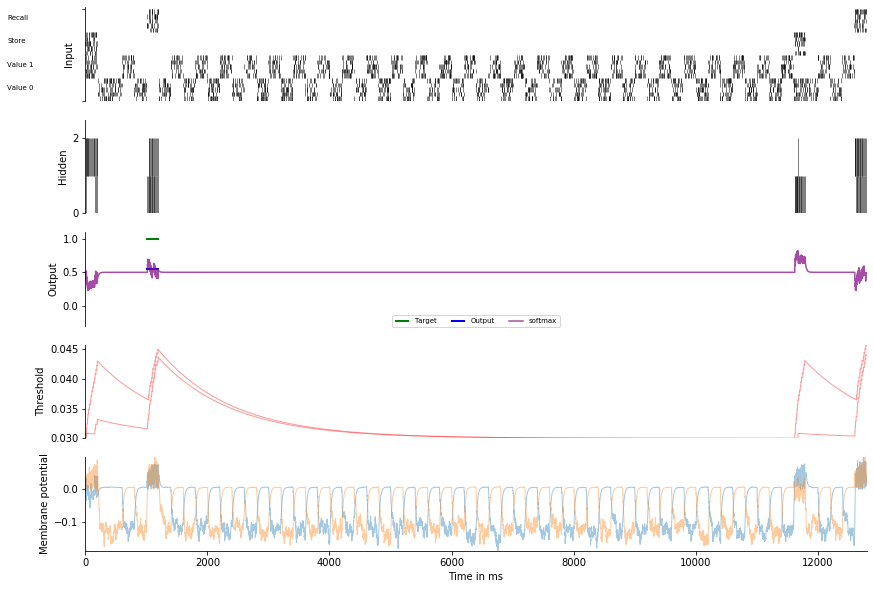

In [57]:
fig, ax_list = plt.subplots(nrows=5, figsize=(14, 10), gridspec_kw={'wspace': 0, 'hspace': 0.2})
update_plot(data, batch=0)
fig.savefig('fig1E_2.svg', format='svg')

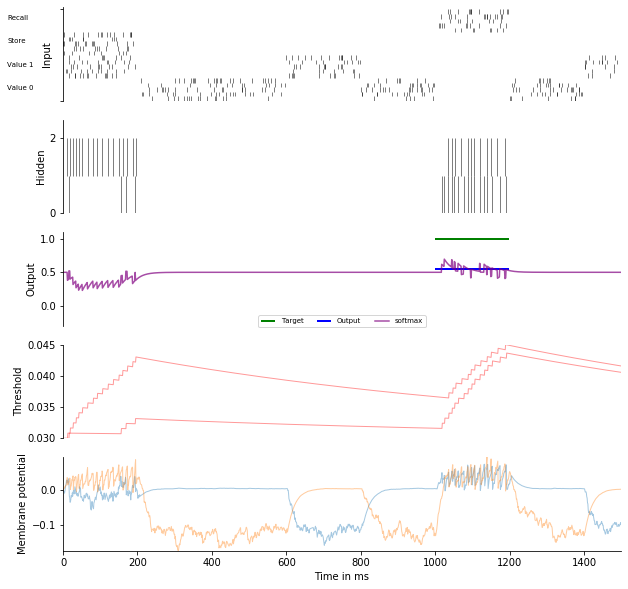

In [58]:
fig, ax_list = plt.subplots(nrows=5, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0.2})
# update_plot(data, batch=0, t_from=0, t_to=3000)
update_plot(data, batch=0, t_from=0, t_to=1500)
fig.savefig('fig1E_12_1.svg', format='svg')

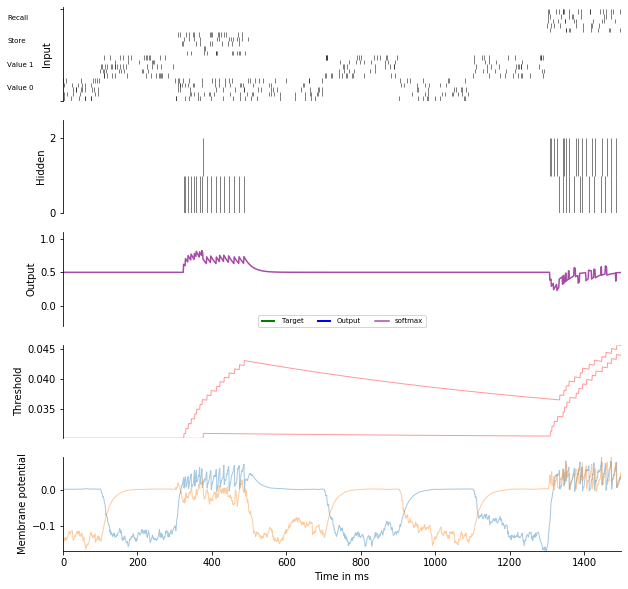

In [59]:
fig, ax_list = plt.subplots(nrows=5, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0.2})
# update_plot(data, batch=0, t_from=data['z'].shape[1] - 3000)
update_plot(data, batch=0, t_from=data['z'].shape[1] - 1500)
fig.savefig('fig1E_12_2.svg', format='svg')

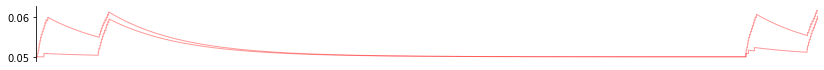

In [52]:
# debug plot for psp-s or biases
fig, ax = plt.subplots(nrows=1, figsize=(14, 1), gridspec_kw={'wspace': 0, 'hspace': 0.2})
ax.clear()
strip_right_top_axis(ax)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
sub_data = data['b_con'][0]
sub_data = sub_data + thr

presentation_steps = np.arange(sub_data.shape[0])
ax.plot(sub_data[:, :], color='r', label='Output', alpha=0.4, linewidth=1)
ax.axis([0, presentation_steps[-1], np.min(sub_data[:, :])-0.001, np.max(sub_data[:, :])+0.001])  # [xmin, xmax, ymin, ymax]
fig.savefig('fig1E_thr.svg', format='svg')

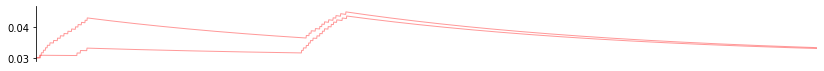

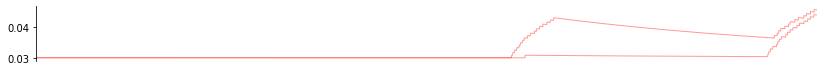

In [62]:
# debug plot for psp-s or biases
fig, ax = plt.subplots(nrows=1, figsize=(14, 1), gridspec_kw={'wspace': 0, 'hspace': 0.2})
ax.clear()
strip_right_top_axis(ax)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
sub_data = data['b_con'][0]
sub_data = sub_data + thr

t_start = 0
t_end = 3000
presentation_steps = np.arange(sub_data[t_start:t_end, :].shape[0])
ax.plot(sub_data[t_start:t_end, :], color='r', label='Output', alpha=0.4, linewidth=1)
ax.axis([0, presentation_steps[-1], np.min(sub_data[t_start:t_end, :])-0.001, np.max(sub_data[:, :])+0.001])  # [xmin, xmax, ymin, ymax]
fig.savefig('fig1E_thr_1.svg', format='svg')

fig, ax = plt.subplots(nrows=1, figsize=(14, 1), gridspec_kw={'wspace': 0, 'hspace': 0.2})
ax.clear()
strip_right_top_axis(ax)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
sub_data = data['b_con'][0]
sub_data = sub_data + thr

t_start = sub_data.shape[0] - 3000
t_end = sub_data.shape[0]
presentation_steps = np.arange(sub_data[t_start:t_end, :].shape[0])
ax.plot(sub_data[t_start:t_end, :], color='r', label='Output', alpha=0.4, linewidth=1)
ax.axis([0, presentation_steps[-1], np.min(sub_data[t_start:t_end, :])-0.001, np.max(sub_data[:, :])+0.001])  # [xmin, xmax, ymin, ymax]
fig.savefig('fig1E_thr_2.svg', format='svg')

In [61]:
sub_data.shape[0]

12800

In [60]:
diffs = []
max_t = data['z'][b].shape[0]

# ranges = [(1400, max_t)]
# ranges = [(500, 1500), (6000, max_t)]
ranges = [(500, 1500), (12000, max_t)]
# ranges = [(1000, 3000), (24000, max_t)]  # tau_char=400

for b in range(FLAGS.batch_test):
    r_diffs = []
    for r in ranges:
        recall_spikes = data['z'][b][r[0]:r[1]]
        recall_spikes = np.sum(recall_spikes, axis=0)
        r_diffs.append(abs(recall_spikes[0] - recall_spikes[1]))
    diffs.append(r_diffs)

for b, diff in enumerate(sorted(diffs)[::-1]):
    print(f"Batch {b:<3}:", diff)

Batch 0  : [6.0, 4.0]
Batch 1  : [5.0, 5.0]
Batch 2  : [5.0, 5.0]
Batch 3  : [5.0, 5.0]
Batch 4  : [5.0, 5.0]
Batch 5  : [5.0, 5.0]
Batch 6  : [5.0, 5.0]
Batch 7  : [5.0, 5.0]
Batch 8  : [5.0, 5.0]
Batch 9  : [5.0, 5.0]
Batch 10 : [5.0, 5.0]
Batch 11 : [5.0, 5.0]
Batch 12 : [5.0, 5.0]
Batch 13 : [5.0, 5.0]
Batch 14 : [5.0, 5.0]
Batch 15 : [5.0, 5.0]
Batch 16 : [5.0, 5.0]
Batch 17 : [5.0, 5.0]
Batch 18 : [5.0, 5.0]
Batch 19 : [5.0, 4.0]
Batch 20 : [5.0, 4.0]
Batch 21 : [5.0, 4.0]
Batch 22 : [5.0, 4.0]
Batch 23 : [5.0, 4.0]
Batch 24 : [5.0, 4.0]
Batch 25 : [5.0, 4.0]
Batch 26 : [5.0, 4.0]
Batch 27 : [5.0, 4.0]
Batch 28 : [5.0, 4.0]
Batch 29 : [5.0, 4.0]
Batch 30 : [5.0, 4.0]
Batch 31 : [5.0, 4.0]
Batch 32 : [5.0, 4.0]
Batch 33 : [5.0, 4.0]
Batch 34 : [5.0, 4.0]
Batch 35 : [5.0, 4.0]
Batch 36 : [5.0, 4.0]
Batch 37 : [5.0, 4.0]
Batch 38 : [5.0, 4.0]
Batch 39 : [5.0, 4.0]
Batch 40 : [5.0, 4.0]
Batch 41 : [5.0, 4.0]
Batch 42 : [5.0, 4.0]
Batch 43 : [5.0, 4.0]
Batch 44 : [5.0, 4.0]
Batch 45 :